In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print("start!")
HIDDEN_SIZE = 64
BATCH_SIZE = 64 # 64
LOG_ITERATIONS = 500
EPOCHS_NUM = 25

start!


In [0]:
# from google.colab import files, drive
# drive.mount('/content/gdrive')
# torch.save(encoder1.state_dict(), "gdrive/My Drive/CompLing/rusdeu10_beam_encoder1.dic")
# print("Hello stackoverflow!", file=open("gdrive/My Drive/CompLing/output.txt", "a"))

In [0]:
# f = open("gdrive/My Drive/CompLing/output.txt", 'a+')
# f.write("Appended line, lol\r\n")
# f.close()
# with open("gdrive/My Drive/CompLing/output.txt", 'a') as f:
#   f.write("Appended line\r\n")
# f.write("Here\r\n")

## План
1. Разбить датасет на трейн/тест или на трейн/валидация/тест, как вам больше нравится
1. Сделать класс нейронки, вписать необходимые операции, базовая архитектура ниже
1. Написать обучалку
1. Добавить логирование
    1. Сохранять лосс на каждой итерции обучения __0.25 балла__
    1. Каждую эпоху сохранять лосс трейна и тест __0.25 балла__
    1. Каждую эпоху рассчитывать метрики __0.25 балла__
    1. Добавить прогресс бар, в котором показывается усредненный лосс последних 500-та итераций __0.25 балла__
1. Добавить early stopping __0.5 балла__
1. Отрисовать графики лосса, метрик, конфьюжин матрицу __0.5 балла__
1. Улучшить результат. Например, можно добавить BatchNorm, Dropout, Residual, etc __1 балл__
1. Сделать макро f1 больше 0.8 __1 балл__
1. Написать какие действия к чему приводили (почему вы их делали и оправдались ли ожидания)

## Базовая архитектура
1. Предобученные эмбеддинги. Почитайте [здесь](https://pytorch.org/docs/stable/nn.html#embedding) (from_pretrained) как вставить свои эмбеддинги, выше мы читали матрицу эмбеддингов. __1 балл__
1. Bidirectional LSTM. __1 балл__
2. Несколько параллельных CNN с разными размерами окна и пулингами к ним. __2 балла__
3. Конкатенация результатов CNN. __0 баллов__ (идет вместе с предыдущим пунктом)
4. Предикт в количество классов. __0 баллов__ (ну все-таки предсказать классы нужно обязательно)

__Дополнительные баллы:__
- Написать GRU с нуля самому __1 балл__
- Побить макро f1 0.84 __1 балл__
- Переобучиться и снизить переобучение за счет трюков. Пояснение: показываете, что вот такая архитектура переобучается, а вот я добавил/а это и это, изменил/а это и это и переобучение ушло __1 балл__
- Добавить селф аттеншин (написанный своими руками) __3 балла__
- За мультихед селф аттеншин еще __1 балл__
- Добавить [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) и [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) для LSTM. Инфа [здесь](#Еще-важный-момент-про-LSTM) __2 балла__
- Добавить дропаут для входа LSTM (не просто стандартный пункт при инициализации LSTM) __1 балл__
- Добавить шедуллеры __1 балл__
- your madness

### TIPs:
- Если будете брать ```train_test_split```, не забудьте сделать ```reset_index```, чтобы по индексу корректно доставались таргеты из ```y_data```  
- Необязательно делить датасет именно на 70 % и 30 %  
- Пулинг можно делать без торчового слоя

# РАЗМЕР ТЕСТА НЕ МЕНЬШЕ 10% ДАТАСЕТА
# 10 БАЛЛОВ МАКСИМУМ

In [4]:
!pip install pandas
!pip install torch
!pip install nltk
!pip install tqdm
!pip install seaborn
!pip install numpy
!pip install sklearn
!pip install pytorch-ignite


     |████████████████████████████████| 92kB 2.9MB/s 


In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Скачиваем данные

In [6]:
!wget https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/blob/master/week_05/data/answers_subsample.csv?raw=true -O data.csv

--2019-10-28 13:47:41--  https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/blob/master/week_05/data/answers_subsample.csv?raw=true
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/raw/master/week_05/data/answers_subsample.csv [following]
--2019-10-28 13:47:42--  https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/raw/master/week_05/data/answers_subsample.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/week_05/data/answers_subsample.csv [following]
--2019-10-28 13:47:42--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/week_05/data/answers_subsample.csv
Resolving raw.githubusercontent.com (raw.gi

In [0]:
# если ругается на то, что нет wget
# !apt-get install wget

In [8]:
!ls -l

total 28052
-rw-r--r-- 1 root root 28717126 Oct 28 13:47 data.csv
drwxr-xr-x 1 root root     4096 Oct 22 15:18 sample_data


In [0]:
import pandas as pd

In [0]:
data = pd.read_csv('data.csv').reset_index()

In [0]:
# data

In [0]:
import re
puncts  = str.maketrans('','',":,?;\"!.«»()\'\*\+\\\/\>\<\=")
def smileproc(b):
  b = re.sub(r"(?<=[А-ЯЁа-яё\d])(?=\))", " ", b)    

  eyes, noses, mouths = r":;8BX=", r"-~'^", r")(/\|DP"
  patsmileys = "[%s][%s]?[%s]" % tuple(map(re.escape, [eyes, noses, mouths]))
  j = re.findall(patsmileys, b)
  patsmile = r"\s\)+"
  h = re.findall(patsmile, b)
  b = re.sub(r"\?", " СПРАШИВАЮ ", b)
  b = re.sub(r"\!", " ВАЖНО ", b)
  if j:
    b = re.sub(patsmileys, " УЛЫБАЮСЬ ", b)
    # print (j, b)
  if h and b.count('(') == 0:
    b = re.sub(patsmile, " УЛЫБАЮСЬ ", b)
    b = re.sub(r"о_о", " УЛЫБАЮСЬ ", b)
    
    # print (h, b)
  b = b.lower().translate(puncts).strip()      
  b = re.sub(r'(?<=\\d)(?=\\w)|(?<=\\w)(?=\\d)', ' ', b)
  return b

In [13]:
%%time
DATA_TEXTS = data.text.tolist()
# for a, row in data.iterrows():  
for a, b in enumerate(DATA_TEXTS):
  # s = row["text"]
  s = b
  # if a > 5000: break
  # if a % 1000 == 0:
  #   print(a)
  res = smileproc(s)
  # data.loc[a, "text"] = res
  DATA_TEXTS[a] = res
  # print(res)


CPU times: user 6.32 s, sys: 43.5 ms, total: 6.36 s
Wall time: 6.38 s


In [0]:
# for a, b in enumerate(data.text):
#   if a > 500: break
#   print(b)
# for a, b in enumerate(tts):
#   if a > 500: break
#   print(b)

In [15]:
data.category.value_counts() * 100 / data.shape[0]

law         29.793211
relax       22.016242
business    19.309527
food        18.367055
love        10.513965
Name: category, dtype: float64

# Предобученные эмбеддинги
[Источник](https://fasttext.cc/docs/en/crawl-vectors.html)  
Вы можете взять любые word2vec подобные эмббединги. Если вы хотите использовать elmo, bert, etc сначала попробуйте с word2vec подобными эмббедингами, а потом можете перейти к более сложным моделям.  
Ниже мы сначала скачиваем, а потом распоковываем эмбеддинги.

In [16]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2019-10-28 13:47:57--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1.22G  11.1MB/s    in 1m 52s  

2019-10-28 13:49:50 (11.1 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]



In [17]:
!ls -l

total 4458144
-rw-r--r-- 1 root root 4536408847 Jan 18  2019 cc.ru.300.vec
-rw-r--r-- 1 root root   28717126 Oct 28 13:47 data.csv
drwxr-xr-x 1 root root       4096 Oct 22 15:18 sample_data


In [0]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm

In [0]:
# потом можете добавить свою предобработку

def process_text(text):    
    words = wordpunct_tokenize(text.lower())
    
    return words

In [20]:
word2freq = {}
lengths = []

# for text in tqdm(data.text):
for text in tqdm(DATA_TEXTS):
    
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

100%|██████████| 237779/237779 [00:02<00:00, 105718.67it/s]


In [0]:
import seaborn as sns
from matplotlib import pyplot as plt

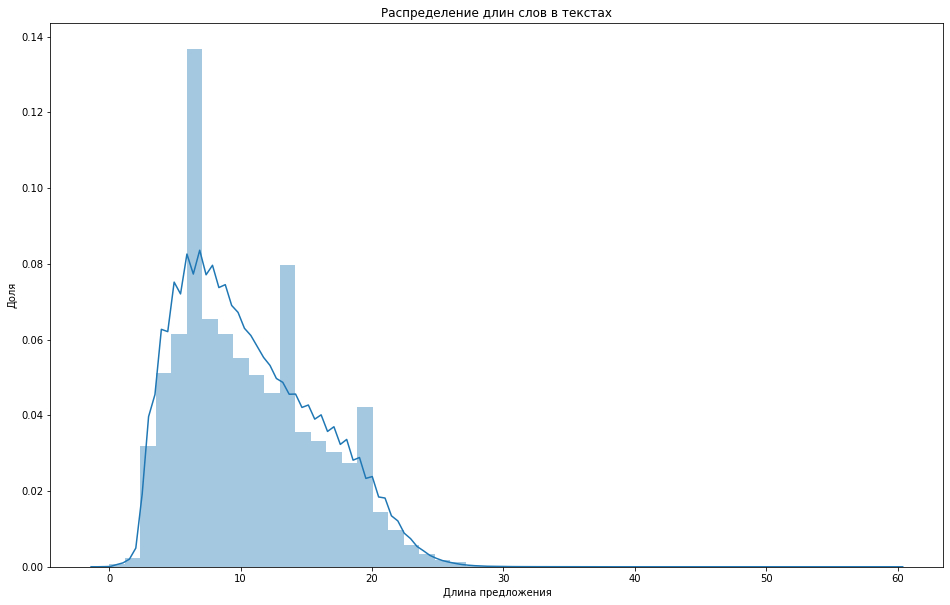

In [22]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [23]:
upper_threshold = 32
lower_threshold = 3

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'99.63 % наших текстов входят в промежуток от 3 до 32 слов'

In [24]:
len(word2freq)

155101

In [25]:
'{} слов, которые встречались 3 и менее раз'.format(len([word for word in word2freq if word2freq[word] <= 3]))

'117640 слов, которые встречались 3 и менее раз'

# Читаем файл с эмбеддингами
### Этот файл с 300 числами для 2 000 000 слов и он может не влезть в память
Поэтому прочитаем только те слова, которые мы знаем

In [0]:
import numpy as np

In [27]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('cc.ru.300.vec')
    
n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break
        
    current_parts = line.split()

    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:

        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec: 100%|██████████| 2000000/2000000 [01:07<00:00, 29679.18it/s]


In [28]:
len(word2index)

117572

In [29]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words, key=lambda x: sub_sample_unk_words[x], reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % уникальных слов в словаре'.format(
    len(unk_words), len(word2freq), len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(50):
    print(sorted_unk_words[i], 'с количеством вхождениий -', word2freq[sorted_unk_words[i]])

Мы не знаем 1.71 % слов в датасете
Количество неизвестных слов 37530 из 155101, то есть 24.20 % уникальных слов в словаре
В среднем каждое встречается 1.16 раз

Топ 5 невошедших слов:
дошик с количеством вхождениий - 43
егрн с количеством вхождениий - 40
слайм с количеством вхождениий - 39
внп с количеством вхождениий - 37
девчин с количеством вхождениий - 36
♪♫ с количеством вхождениий - 31
wwwyoutubecomwatch с количеством вхождениий - 25
hatsan с количеством вхождениий - 25
%- с количеством вхождениий - 23
сзв с количеством вхождениий - 19
комиссация с количеством вхождениий - 18
кафересторан с количеством вхождениий - 18
кдн с количеством вхождениий - 17
boozled с количеством вхождениий - 17
фкз с количеством вхождениий - 16
помогитее с количеством вхождениий - 15
быстроденьги с количеством вхождениий - 15
```` с количеством вхождениий - 15
бсо с количеством вхождениий - 15
алиекспресс с количеством вхождениий - 15
` с количеством вхождениий - 14
слаймов с количеством вхождениий - 1

# Потеря 2.5 % слов в датасете
Эта ситуация не то, чтобы сильно плохая, в учебных целях нормально, к тому же в среднем они редко встречаются. Вы можете поиграть с предобработкой, но советую не заигрываться. Оценивается другое.

In [0]:
import torch

# Подготовим данные в DataLoader

In [0]:
from torch.utils.data import Dataset, DataLoader

In [32]:
'UNK' in word2index

False

# Замапим категории в индексы

In [0]:
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}
inv_cat_mapper =  {v: k for k, v in cat_mapper.items()}

In [34]:
inv_cat_mapper.keys()

dict_keys([0, 1, 2, 3, 4])

In [35]:
cat_mapper

{'business': 0, 'food': 4, 'law': 1, 'love': 2, 'relax': 3}

In [36]:
len(cat_mapper)

5

In [0]:
data_cats = data.category.map(cat_mapper)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(DATA_TEXTS, data_cats.tolist(), test_size=0.2)

In [39]:
x_train[:10]

['монгольская молочная водка вкусная спрашиваю  спрашиваю',
 'можно ли есть томаты при аллергии спрашиваю  интерес',
 'можно ли глотать семечки от дыни спрашиваю  есть ли в этом польза спрашиваю',
 'как вам нравится качество сервиса спрашиваю  смотри внутри',
 'как приготовить суп без кипяенной воды спрашиваю',
 'ваше мнение важно  в каком из двух банков вы бы выбрали для вклада спрашиваю  и почему спрашиваю  желательно плюсы и минусы',
 'как пройти тестирование на workle спрашиваю',
 'виски - множественное число',
 'вам не надоела одна и та же рожа на нг  спрашиваю',
 'помогите выбрать посоветуйте катушку под ультра лайт favorite blue bird 1-7g']

In [40]:
y_train[:10]


[4, 4, 4, 3, 4, 0, 0, 4, 3, 3]

# Читалка данных

## Что происходит ниже
1. Мы задаем x_data, y_data (таргеты), word2index (маппер из слова в индекс слова), sequence_length (максимальная длина последовательности, если больше, ограничить ею), pad_token (токен паддинга и задаем его индекс pad_index).
1. Загружаем данные:
    1. Проходимся по датасету
    1. Предобрабатываем каждый текст в датасете
    1. Индексируем его
1. Когда нам нужно достать пример из датасета мы берем индексированный ```x``` и соответствующий этому индексу ```y```, наш ```x``` также паддим (или ограничиваем длину) и переводим в ```torch.Tensor(x).long()```. Для ```y``` этого делать не потребуется, в dataloader'е таргеты преобразуются в тензор сами.
    
## Что нужно сделать здесь
1. Дописать индексатор текста
1. Дописать паддинг текста
1. __*Опционально:*__ добавить что-то в предобработку

In [0]:
from itertools import repeat

In [0]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length=32, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = []
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, y_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        
        # Место для вашей предобработки        
        # aftertext = text.lower().translate(puncts).strip()        
        # words = wordpunct_tokenize(digisep(aftertext))

        words = wordpunct_tokenize(text)

        return words
        
    def load(self, data, data2, verbose=True):
        
        data_iterator = tqdm(range(len(data)), desc='Loading data', disable=not verbose, position=0)
        
        for i in data_iterator:
            
            words = self.process_text(data[i])
            
            indexed_words = self.indexing(words)
            if indexed_words:
              self.x_data.append(indexed_words)
              self.y_data.append(data2[i])
              # print("O_o")
            
            
    
    def indexing(self, tokenized_text):

        # здесь мы не используем токен UNK, потому что мы мы его специально не учили
        # становится непонятно какой же эмбеддинг присвоить неизвестному слову,
        # поэтому просто выбрасываем наши неизветсные слова        
        ### CODE ###
        return [self.word2index[token] for token in tokenized_text if token in self.word2index]
        
            
    def padding(self, sequence):
        
        # Ограничить длину self.sequence_length
        # если длина меньше максимально - западить
        ### CODE ###        
        delta = self.sequence_length - len(sequence)
        return sequence + list(repeat(self.pad_index, delta)) \
        if delta > 0 else sequence[:self.sequence_length]

    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y_data[idx]
        
        return x, y

In [43]:
dataset = WordData(x_train, y_train, word2index)
datasettest = WordData(x_test, y_test, word2index)
# dataset = WordData(data.text, data.category, word2index)


Loading data: 100%|██████████| 47556/47556 [00:00<00:00, 101183.59it/s]


In [0]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(datasettest, batch_size=BATCH_SIZE, pin_memory=True)

In [0]:
import warnings
warnings.filterwarnings('ignore')
# warnings break progress bar

In [49]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
torch.set_printoptions(profile="full")

def nsort(y):
  ll, ii = (y > 0).sum(1).sort(descending=True)
  return y[ii], ll

def tsort(ts):
  z = torch.tensor([len(torch.nonzero(ts[i])) for i in range(ts.shape[0])]).sort(descending=True)
  return ts[z[1]], z[0], np.argsort(z[1]).to(device)

class CoolNet(nn.Module):
  """
  |￣￣￣￣￣￣￣￣￣￣￣|
    I don't know
    what I am doing,
    but it is my neural
    network
  |＿＿＿＿＿＿＿＿＿＿＿|
  (\__/) ||
  (•ㅅ•) ||
  / 　 づ
  """
 
  def __init__(self, vocab_size, hidden_dim, classes_quantity, emb_weights, seqlen = 32, debug_file=None):
    super().__init__()
    self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(emb_weights))
    self.drop = nn.Dropout2d(0.25)    
    embedding_length  = emb_weights.shape[1]
    self.lstm = nn.LSTM(input_size=embedding_length,\
                        hidden_size=hidden_dim,\
                        bidirectional=True, batch_first=True)
    self.linear = nn.Linear(hidden_dim*2, classes_quantity)    

    kerns = [2,4,6,8]
    # con_size = embedding_length
    con_size = hidden_dim * 2

    self.conv1 = nn.Conv1d(in_channels=con_size, out_channels= hidden_dim, kernel_size=kerns[0])
    self.conv2 = nn.Conv1d(in_channels=con_size, out_channels= hidden_dim, kernel_size=kerns[1])
    self.conv3 = nn.Conv1d(in_channels=con_size, out_channels= hidden_dim, kernel_size=kerns[2])
    self.conv4 = nn.Conv1d(in_channels=con_size, out_channels= hidden_dim, kernel_size=kerns[3])

    self.mp1 = nn.MaxPool1d(kernel_size=(seqlen-kerns[0]+1))
    self.mp2 = nn.MaxPool1d(kernel_size=(seqlen-kerns[1]+1))
    self.mp3 = nn.MaxPool1d(kernel_size=(seqlen-kerns[2]+1))
    self.mp4 = nn.MaxPool1d(kernel_size=(seqlen-kerns[3]+1))
    self.relu = nn.ReLU()
    
    self.f  = debug_file
    pass



  def forward(self, x):    
    x_sorted, lens, unindex = tsort(x)
    # print("orig", x.shape, len(lens))
    x = self.embeddings(x_sorted)
    # x = self.embeddings(x)
    x = self.drop(x)   
    # print("emb", x.shape)
    z = pack_padded_sequence(x, lens, batch_first=True)
    x, _ =  self.lstm(z)
        # x, _ =  self.lstm(x)
        # x = x[:, -1, :]
    x, _ = pad_packed_sequence(x, batch_first=True)
    # print("lstm out", x.shape)
    x = x.index_select(0, unindex)
        # print("lstm2", x.shape)
    x = x.transpose(0, 1)

        # print("lstm3", x.shape)



    # x_transposed = x.transpose(1, 2) 
    
        # print("conv in", x_transposed.shape)

    # x1 = F.relu(self.conv1(x_transposed))
    # x2 = F.relu(self.conv2(x_transposed))
    # x3 = F.relu(self.conv3(x_transposed))
    # x4 = F.relu(self.conv4(x_transposed))

          # print("x1", x1.shape)
          # print("x2", x2.shape)
          # print("x3", x3.shape)
          # print("x4", x4.shape)

    # x1 = x1.transpose(0,2)
    # x2 = x2.transpose(0,2)
    # x3 = x3.transpose(0,2)
    # x4 = x4.transpose(0,2)
    
    # mp1x = self.mp1(x1)
    # mp2x = self.mp2(x2)
    # mp3x = self.mp3(x3)
    # mp4x = self.mp4(x4)

          # print("mp out", mp1x.shape)

    # x_cat = torch.cat((mp1x, mp2x, mp3x, mp4x), 0)
        # print("after cnn",x_cat.shape)
        # x = x_cat.transpose(1, 2)
        # print("cnn trans",x.shape)
    
    x = x[0]

    # x = x[:, -1, :]

    x = self.drop(x)
    x = self.linear(x)
    return x



# f = open("gdrive/My Drive/CompLing/output.txt", 'a+')
f = None



model = CoolNet(vocab_size=len(word2index), hidden_dim = HIDDEN_SIZE,\
                classes_quantity = len(cat_mapper),\
                emb_weights = vectors, debug_file=f)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# torch.cuda.empty_cache()
print("CUDA RAM usage", torch.cuda.max_memory_allocated(device))
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())
# aka loss function
criterion = torch.nn.CrossEntropyLoss()

CUDA RAM usage 287344128


Current device cuda
Learning rate: 0.0005


Epoch[1] Iteration[500/2972] Loss: 0.8640
Epoch[1] Iteration[1000/2972] Loss: 0.7283
Epoch[1] Iteration[1500/2972] Loss: 0.9343
Epoch[1] Iteration[2000/2972] Loss: 0.5734
Epoch[1] Iteration[2500/2972] Loss: 0.6954
Compute train metrics...
Training Results - Epoch: 1  Average Loss: 0.5400 | Accuracy: 0.8072 | Precision: 0.8027 | Recall: 0.8074  | F1: 0.8048
Compute validation metrics...
Validation Results - Epoch: 1  Average Loss: 0.5503 | Accuracy: 0.8038 | Precision: 0.7999 | Recall: 0.8042 | F1: 0.8018
Learning rate: 0.001


Epoch[2] Iteration[500/2972] Loss: 0.5750
Epoch[2] Iteration[1000/2972] Loss: 0.8073
Epoch[2] Iteration[1500/2972] Loss: 0.7498
Epoch[2] Iteration[2000/2972] Loss: 0.4404
Epoch[2] Iteration[2500/2972] Loss: 0.7179
Compute train metrics...
Training Results - Epoch: 2  Average Loss: 0.4954 | Accuracy: 0.8205 | Precision: 0.8178 | Recall: 0.8184  | F1: 0.8176
Compute validation metrics...
Validation Results - Epoch: 2  Average Loss: 0.5084 | Accuracy: 0.8161 | Precision: 0.8141 | Recall: 0.8138 | F1: 0.8132
Learning rate: 0.0005


Epoch[3] Iteration[500/2972] Loss: 0.4611
Epoch[3] Iteration[1000/2972] Loss: 0.6742
Epoch[3] Iteration[1500/2972] Loss: 0.6146
Epoch[3] Iteration[2000/2972] Loss: 0.4550
Epoch[3] Iteration[2500/2972] Loss: 0.6033
Compute train metrics...
Training Results - Epoch: 3  Average Loss: 0.4735 | Accuracy: 0.8288 | Precision: 0.8261 | Recall: 0.8265  | F1: 0.8261
Compute validation metrics...
Validation Results - Epoch: 3  Average Loss: 0.4876 | Accuracy: 0.8238 | Precision: 0.8216 | Recall: 0.8214 | F1: 0.8213
Learning rate: 0.001


Epoch[4] Iteration[500/2972] Loss: 0.5039
Epoch[4] Iteration[1000/2972] Loss: 0.6939
Epoch[4] Iteration[1500/2972] Loss: 0.5560
Epoch[4] Iteration[2000/2972] Loss: 0.5569
Epoch[4] Iteration[2500/2972] Loss: 0.5945
Compute train metrics...
Training Results - Epoch: 4  Average Loss: 0.4573 | Accuracy: 0.8345 | Precision: 0.8319 | Recall: 0.8323  | F1: 0.8320
Compute validation metrics...
Validation Results - Epoch: 4  Average Loss: 0.4735 | Accuracy: 0.8278 | Precision: 0.8252 | Recall: 0.8253 | F1: 0.8251
Learning rate: 0.0005


Epoch[5] Iteration[500/2972] Loss: 0.5055
Epoch[5] Iteration[1000/2972] Loss: 0.5144
Epoch[5] Iteration[1500/2972] Loss: 0.5183
Epoch[5] Iteration[2000/2972] Loss: 0.5362
Epoch[5] Iteration[2500/2972] Loss: 0.5350
Compute train metrics...
Training Results - Epoch: 5  Average Loss: 0.4468 | Accuracy: 0.8373 | Precision: 0.8353 | Recall: 0.8353  | F1: 0.8352
Compute validation metrics...
Validation Results - Epoch: 5  Average Loss: 0.4651 | Accuracy: 0.8311 | Precision: 0.8297 | Recall: 0.8290 | F1: 0.8292
Learning rate: 0.001


Epoch[6] Iteration[500/2972] Loss: 0.4430
Epoch[6] Iteration[1000/2972] Loss: 0.5485
Epoch[6] Iteration[1500/2972] Loss: 0.5042
Epoch[6] Iteration[2000/2972] Loss: 0.4404
Epoch[6] Iteration[2500/2972] Loss: 0.5941
Compute train metrics...
Training Results - Epoch: 6  Average Loss: 0.4398 | Accuracy: 0.8401 | Precision: 0.8372 | Recall: 0.8386  | F1: 0.8376
Compute validation metrics...
Validation Results - Epoch: 6  Average Loss: 0.4607 | Accuracy: 0.8324 | Precision: 0.8301 | Recall: 0.8304 | F1: 0.8298
Learning rate: 0.0005


Epoch[7] Iteration[500/2972] Loss: 0.5566
Epoch[7] Iteration[1000/2972] Loss: 0.5788
Epoch[7] Iteration[1500/2972] Loss: 0.6322
Epoch[7] Iteration[2000/2972] Loss: 0.5469
Epoch[7] Iteration[2500/2972] Loss: 0.6045
Compute train metrics...
Training Results - Epoch: 7  Average Loss: 0.4306 | Accuracy: 0.8427 | Precision: 0.8382 | Recall: 0.8437  | F1: 0.8407
Compute validation metrics...
Validation Results - Epoch: 7  Average Loss: 0.4536 | Accuracy: 0.8344 | Precision: 0.8306 | Recall: 0.8348 | F1: 0.8325
Learning rate: 0.001


Epoch[8] Iteration[500/2972] Loss: 0.5750
Epoch[8] Iteration[1000/2972] Loss: 0.5566
Epoch[8] Iteration[1500/2972] Loss: 0.5202
Epoch[8] Iteration[2000/2972] Loss: 0.4968
Epoch[8] Iteration[2500/2972] Loss: 0.5628
Compute train metrics...
Training Results - Epoch: 8  Average Loss: 0.4236 | Accuracy: 0.8450 | Precision: 0.8447 | Recall: 0.8418  | F1: 0.8432
Compute validation metrics...
Validation Results - Epoch: 8  Average Loss: 0.4498 | Accuracy: 0.8354 | Precision: 0.8359 | Recall: 0.8314 | F1: 0.8335
Learning rate: 0.0005


Epoch[9] Iteration[500/2972] Loss: 0.4522
Epoch[9] Iteration[1000/2972] Loss: 0.6428
Epoch[9] Iteration[1500/2972] Loss: 0.4860
Epoch[9] Iteration[2000/2972] Loss: 0.4384
Epoch[9] Iteration[2500/2972] Loss: 0.6514
Compute train metrics...
Training Results - Epoch: 9  Average Loss: 0.4145 | Accuracy: 0.8486 | Precision: 0.8460 | Recall: 0.8474  | F1: 0.8466
Compute validation metrics...
Validation Results - Epoch: 9  Average Loss: 0.4435 | Accuracy: 0.8382 | Precision: 0.8365 | Recall: 0.8366 | F1: 0.8364
Learning rate: 0.001


Epoch[10] Iteration[500/2972] Loss: 0.5365
Epoch[10] Iteration[1000/2972] Loss: 0.5468
Epoch[10] Iteration[1500/2972] Loss: 0.5030
Epoch[10] Iteration[2000/2972] Loss: 0.3488
Epoch[10] Iteration[2500/2972] Loss: 0.5321
Compute train metrics...
Training Results - Epoch: 10  Average Loss: 0.4144 | Accuracy: 0.8483 | Precision: 0.8468 | Recall: 0.8473  | F1: 0.8469
Compute validation metrics...
Validation Results - Epoch: 10  Average Loss: 0.4449 | Accuracy: 0.8377 | Precision: 0.8369 | Recall: 0.8360 | F1: 0.8363
Learning rate: 0.0005


Epoch[11] Iteration[500/2972] Loss: 0.4884
Epoch[11] Iteration[1000/2972] Loss: 0.5185
Epoch[11] Iteration[1500/2972] Loss: 0.4993
Epoch[11] Iteration[2000/2972] Loss: 0.4008
Epoch[11] Iteration[2500/2972] Loss: 0.5027
Compute train metrics...
Training Results - Epoch: 11  Average Loss: 0.4052 | Accuracy: 0.8523 | Precision: 0.8487 | Recall: 0.8523  | F1: 0.8505
Compute validation metrics...
Validation Results - Epoch: 11  Average Loss: 0.4396 | Accuracy: 0.8394 | Precision: 0.8367 | Recall: 0.8394 | F1: 0.8380
Learning rate: 0.001


Epoch[12] Iteration[500/2972] Loss: 0.4568
Epoch[12] Iteration[1000/2972] Loss: 0.5512
Epoch[12] Iteration[1500/2972] Loss: 0.3361
Epoch[12] Iteration[2000/2972] Loss: 0.4572
Epoch[12] Iteration[2500/2972] Loss: 0.5784
Compute train metrics...
Training Results - Epoch: 12  Average Loss: 0.4064 | Accuracy: 0.8513 | Precision: 0.8508 | Recall: 0.8494  | F1: 0.8500
Compute validation metrics...
Validation Results - Epoch: 12  Average Loss: 0.4413 | Accuracy: 0.8390 | Precision: 0.8392 | Recall: 0.8367 | F1: 0.8379
Learning rate: 0.0005


Epoch[13] Iteration[500/2972] Loss: 0.4754
Epoch[13] Iteration[1000/2972] Loss: 0.6268
Epoch[13] Iteration[1500/2972] Loss: 0.4385
Epoch[13] Iteration[2000/2972] Loss: 0.4961
Epoch[13] Iteration[2500/2972] Loss: 0.5752
Compute train metrics...
Training Results - Epoch: 13  Average Loss: 0.3952 | Accuracy: 0.8552 | Precision: 0.8535 | Recall: 0.8533  | F1: 0.8533
Compute validation metrics...
Validation Results - Epoch: 13  Average Loss: 0.4349 | Accuracy: 0.8423 | Precision: 0.8416 | Recall: 0.8402 | F1: 0.8408
Learning rate: 0.001


Epoch[14] Iteration[500/2972] Loss: 0.4468
Epoch[14] Iteration[1000/2972] Loss: 0.4839
Epoch[14] Iteration[1500/2972] Loss: 0.5581
Epoch[14] Iteration[2000/2972] Loss: 0.4124
Epoch[14] Iteration[2500/2972] Loss: 0.5130
Compute train metrics...
Training Results - Epoch: 14  Average Loss: 0.3969 | Accuracy: 0.8538 | Precision: 0.8506 | Recall: 0.8544  | F1: 0.8523
Compute validation metrics...
Validation Results - Epoch: 14  Average Loss: 0.4380 | Accuracy: 0.8398 | Precision: 0.8373 | Recall: 0.8400 | F1: 0.8385
Learning rate: 0.0005


Epoch[15] Iteration[500/2972] Loss: 0.4466
Epoch[15] Iteration[1000/2972] Loss: 0.5279
Epoch[15] Iteration[1500/2972] Loss: 0.3323
Epoch[15] Iteration[2000/2972] Loss: 0.5007
Epoch[15] Iteration[2500/2972] Loss: 0.5267
Compute train metrics...
Training Results - Epoch: 15  Average Loss: 0.3861 | Accuracy: 0.8580 | Precision: 0.8550 | Recall: 0.8566  | F1: 0.8556
Compute validation metrics...
Validation Results - Epoch: 15  Average Loss: 0.4316 | Accuracy: 0.8426 | Precision: 0.8405 | Recall: 0.8411 | F1: 0.8405
Learning rate: 0.001


Epoch[16] Iteration[500/2972] Loss: 0.4819
Epoch[16] Iteration[1000/2972] Loss: 0.5012
Epoch[16] Iteration[1500/2972] Loss: 0.5676
Epoch[16] Iteration[2000/2972] Loss: 0.5120
Epoch[16] Iteration[2500/2972] Loss: 0.4647
Compute train metrics...
Training Results - Epoch: 16  Average Loss: 0.3870 | Accuracy: 0.8583 | Precision: 0.8567 | Recall: 0.8566  | F1: 0.8567
Compute validation metrics...
Validation Results - Epoch: 16  Average Loss: 0.4343 | Accuracy: 0.8426 | Precision: 0.8416 | Recall: 0.8410 | F1: 0.8413
Learning rate: 0.0005


Epoch[17] Iteration[500/2972] Loss: 0.3987
Epoch[17] Iteration[1000/2972] Loss: 0.5571
Epoch[17] Iteration[1500/2972] Loss: 0.3671
Epoch[17] Iteration[2000/2972] Loss: 0.4324
Epoch[17] Iteration[2500/2972] Loss: 0.4477
Compute train metrics...
Training Results - Epoch: 17  Average Loss: 0.3806 | Accuracy: 0.8599 | Precision: 0.8578 | Recall: 0.8588  | F1: 0.8581
Compute validation metrics...
Validation Results - Epoch: 17  Average Loss: 0.4318 | Accuracy: 0.8420 | Precision: 0.8409 | Recall: 0.8405 | F1: 0.8405
Learning rate: 0.001


Epoch[18] Iteration[500/2972] Loss: 0.4450
Epoch[18] Iteration[1000/2972] Loss: 0.4724
Epoch[18] Iteration[1500/2972] Loss: 0.5090
Epoch[18] Iteration[2000/2972] Loss: 0.4440
Epoch[18] Iteration[2500/2972] Loss: 0.4256
Compute train metrics...
Training Results - Epoch: 18  Average Loss: 0.3830 | Accuracy: 0.8598 | Precision: 0.8588 | Recall: 0.8581  | F1: 0.8583
Compute validation metrics...
Validation Results - Epoch: 18  Average Loss: 0.4347 | Accuracy: 0.8421 | Precision: 0.8417 | Recall: 0.8397 | F1: 0.8406
Learning rate: 0.0005


Epoch[19] Iteration[500/2972] Loss: 0.4687
Epoch[19] Iteration[1000/2972] Loss: 0.5048
Epoch[19] Iteration[1500/2972] Loss: 0.3807
Epoch[19] Iteration[2000/2972] Loss: 0.3461
Epoch[19] Iteration[2500/2972] Loss: 0.5278
Compute train metrics...
Training Results - Epoch: 19  Average Loss: 0.3728 | Accuracy: 0.8630 | Precision: 0.8598 | Recall: 0.8616  | F1: 0.8604
Compute validation metrics...
Validation Results - Epoch: 19  Average Loss: 0.4284 | Accuracy: 0.8439 | Precision: 0.8414 | Recall: 0.8422 | F1: 0.8413
Learning rate: 0.001


Epoch[20] Iteration[500/2972] Loss: 0.3612
Epoch[20] Iteration[1000/2972] Loss: 0.4814
Epoch[20] Iteration[1500/2972] Loss: 0.3914
Epoch[20] Iteration[2000/2972] Loss: 0.4431
Epoch[20] Iteration[2500/2972] Loss: 0.5945
Compute train metrics...
Training Results - Epoch: 20  Average Loss: 0.3723 | Accuracy: 0.8630 | Precision: 0.8612 | Recall: 0.8608  | F1: 0.8608
Compute validation metrics...
Validation Results - Epoch: 20  Average Loss: 0.4298 | Accuracy: 0.8441 | Precision: 0.8428 | Recall: 0.8414 | F1: 0.8418
Learning rate: 0.0005


Epoch[21] Iteration[500/2972] Loss: 0.4985
Epoch[21] Iteration[1000/2972] Loss: 0.5960
Epoch[21] Iteration[1500/2972] Loss: 0.4253
Epoch[21] Iteration[2000/2972] Loss: 0.4375
Epoch[21] Iteration[2500/2972] Loss: 0.3908
Compute train metrics...
Training Results - Epoch: 21  Average Loss: 0.3672 | Accuracy: 0.8649 | Precision: 0.8610 | Recall: 0.8650  | F1: 0.8628
Compute validation metrics...
Validation Results - Epoch: 21  Average Loss: 0.4286 | Accuracy: 0.8437 | Precision: 0.8404 | Recall: 0.8435 | F1: 0.8417
Learning rate: 0.001


Epoch[22] Iteration[500/2972] Loss: 0.4735
Epoch[22] Iteration[1000/2972] Loss: 0.5759
Epoch[22] Iteration[1500/2972] Loss: 0.3949
Epoch[22] Iteration[2000/2972] Loss: 0.5427
Epoch[22] Iteration[2500/2972] Loss: 0.4311
Compute train metrics...
Training Results - Epoch: 22  Average Loss: 0.3668 | Accuracy: 0.8653 | Precision: 0.8633 | Recall: 0.8637  | F1: 0.8635
Compute validation metrics...
Validation Results - Epoch: 22  Average Loss: 0.4298 | Accuracy: 0.8435 | Precision: 0.8418 | Recall: 0.8417 | F1: 0.8417
Learning rate: 0.0005


Epoch[23] Iteration[500/2972] Loss: 0.4168
Epoch[23] Iteration[1000/2972] Loss: 0.4867
Epoch[23] Iteration[1500/2972] Loss: 0.3959
Epoch[23] Iteration[2000/2972] Loss: 0.4534
Epoch[23] Iteration[2500/2972] Loss: 0.4936
Compute train metrics...
Training Results - Epoch: 23  Average Loss: 0.3608 | Accuracy: 0.8673 | Precision: 0.8628 | Recall: 0.8671  | F1: 0.8647
Compute validation metrics...
Validation Results - Epoch: 23  Average Loss: 0.4283 | Accuracy: 0.8449 | Precision: 0.8412 | Recall: 0.8442 | F1: 0.8423
Learning rate: 0.001


Epoch[24] Iteration[500/2972] Loss: 0.3564
Epoch[24] Iteration[1000/2972] Loss: 0.5617
Epoch[24] Iteration[1500/2972] Loss: 0.3338
Epoch[24] Iteration[2000/2972] Loss: 0.4216
Epoch[24] Iteration[2500/2972] Loss: 0.5554
Compute train metrics...
Training Results - Epoch: 24  Average Loss: 0.3608 | Accuracy: 0.8682 | Precision: 0.8670 | Recall: 0.8661  | F1: 0.8664
Compute validation metrics...
Validation Results - Epoch: 24  Average Loss: 0.4286 | Accuracy: 0.8446 | Precision: 0.8438 | Recall: 0.8419 | F1: 0.8427
Learning rate: 0.0005


Epoch[25] Iteration[500/2972] Loss: 0.4296
Epoch[25] Iteration[1000/2972] Loss: 0.4635
Epoch[25] Iteration[1500/2972] Loss: 0.3972
Epoch[25] Iteration[2000/2972] Loss: 0.4655
Epoch[25] Iteration[2500/2972] Loss: 0.4504
Compute train metrics...
Training Results - Epoch: 25  Average Loss: 0.3537 | Accuracy: 0.8694 | Precision: 0.8666 | Recall: 0.8687  | F1: 0.8675
Compute validation metrics...
Validation Results - Epoch: 25  Average Loss: 0.4270 | Accuracy: 0.8449 | Precision: 0.8426 | Recall: 0.8434 | F1: 0.8429
Compute final results...
Final F1 0.8429
Learning process is completed.


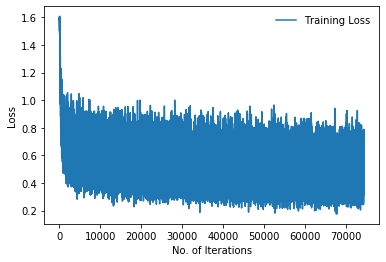

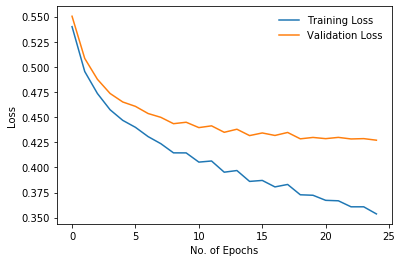

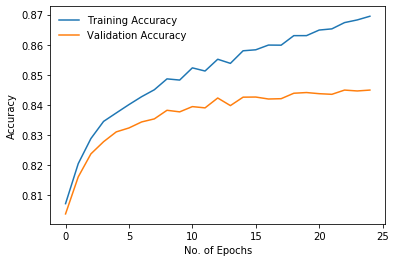

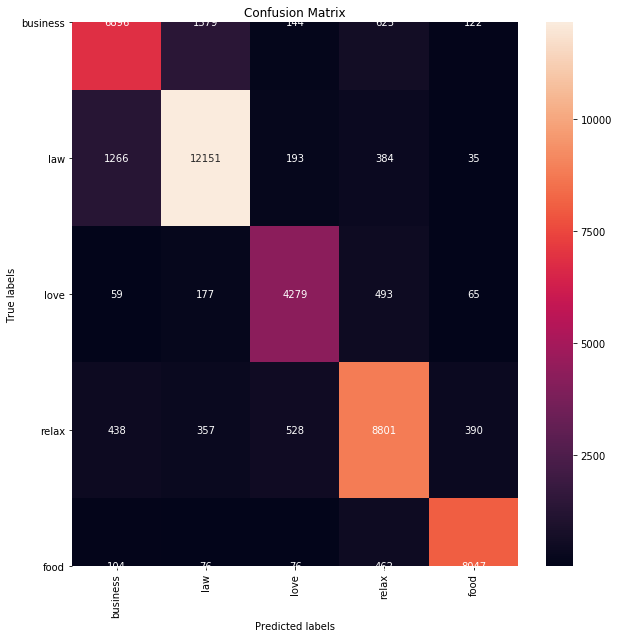

In [50]:
from ignite.engine import Engine, _prepare_batch, Events, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy, Precision, Recall, Loss, ConfusionMatrix, IoU, MetricsLambda
from ignite.contrib.handlers import ProgressBar
from ignite.handlers import EarlyStopping
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingWarmRestarts



# lr_scheduler = ExponentialLR(optimizer, gamma=0.8)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = 2)

def f1(precision, recall):  
  #  + 1e-20
  # res = precision * recall * 2 / (precision + recall)
  # res = MetricsLambda(lambda t: torch.mean(t).item(), res)
  res = (precision * recall * 2 / (precision + recall)).mean()
  return res

log_interval = LOG_ITERATIONS
epochs = EPOCHS_NUM

metrics = {
    'avg_loss': Loss(criterion),
    'avg_accuracy': Accuracy(),
    'avg_precision': Precision(average=True),
    'avg_recall': Recall(average=True),
    'prec': Precision(average=False),
    'rec': Recall(average=False),
    'nll': Loss(criterion),
    'cm': ConfusionMatrix(num_classes=len(cat_mapper))
}

def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = _prepare_batch(batch, device=device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def create_supervised_evaluator(model, metrics={}, device=None):
    if device:
        model.to(device)

    def _inference(engine, batch):
        model.eval()
        with torch.no_grad():
            x, y = _prepare_batch(batch, device=device)
            y_pred = model(x)
            return y_pred, y

    engine = Engine(_inference)

    for name, metric in metrics.items():
        metric.attach(engine, name)

    return engine    
################################################################################
print("Current device", device)

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

# trainer = Engine(process_function)

from ignite.engine import create_supervised_trainer

trainer = create_supervised_trainer(model, optimizer, criterion, device)

training_history = {'accuracy':[],'loss':[], 'f1':[]}
validation_history = {'accuracy':[],'loss':[], 'f1':[]}
loss_history = []

def score_function(engine):
    # loss growth monitoring
    # val_loss = engine.state.metrics['nll']
    # return -val_loss
    # f1
    return f1(engine.state.metrics['prec'], engine.state.metrics['rec'])

early_stopping = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, early_stopping)

pbar = ProgressBar()
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

# cm = ConfusionMatrix(num_classes=5)
# IoU(cm, ignore_index=0).attach(train_evaluator, 'IoU')

@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Display learning rate:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
        print("Learning rate: {}".format(lr))
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])
            print("Learning rate (group {}): {}".format(i, lr))


@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    # f.close()
    iteration = (engine.state.iteration - 1) % len(train_loader) + 1
    loss_history.append(engine.state.output)
    if iteration % log_interval == 0:
        print("Epoch[{}] Iteration[{}/{}] Loss: {:.4f}"
              .format(engine.state.epoch, 
                         iteration, 
                         len(train_loader), 
                         engine.state.output))


@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_offline_train_metrics(engine):
    epoch = engine.state.epoch
    print("Compute train metrics...")
    metrics = train_evaluator.run(train_loader).metrics
    f1val = f1(metrics['prec'], metrics['rec'])
    accuracy = metrics['avg_accuracy']
    training_history['accuracy'].append(accuracy)
    avgloss  = metrics['avg_loss']
    training_history['loss'].append(avgloss)
    training_history['f1'].append(f1)

  
    print("Training Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}  | F1: {:.4f}"
          .format(engine.state.epoch, 
                      avgloss, 
                      metrics['avg_accuracy'], 
                      metrics['avg_precision'], 
                      metrics['avg_recall'],
                      f1val
                  ))

@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    print("Compute validation metrics...")
    metrics = val_evaluator.run(test_loader).metrics
    f1val = f1(metrics['prec'], metrics['rec'])
    
    accuracy = metrics['avg_accuracy']
    validation_history['accuracy'].append(accuracy)    
    avgloss  = metrics['avg_loss']
    validation_history['loss'].append(avgloss)
    validation_history['f1'].append(f1)    
    # print("prec", metrics['prec'])
    # print("recall", metrics['rec'])
    # macrof1 = 0
    # for i in range(len(cat_mapper)):
    #   class_f1 = 2 * metrics['prec'][i] * metrics['rec'][i] / (metrics['prec'][i] + metrics['rec'][i])
    #   class_f1 = class_f1.item()
    #   macrof1 += class_f1
    #   print("cls "+str(i)+" f1", str(class_f1))
    # print("MACRO f1 " + str(macrof1/len(cat_mapper)))
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1: {:.4f}"
          .format(engine.state.epoch, 
                      metrics['avg_loss'], 
                      accuracy, 
                      metrics['avg_precision'], 
                      metrics['avg_recall'],
                     f1val
                  ))

@trainer.on(Events.COMPLETED)
def display_farewell(engine):
  print("Compute final results...")  
  metrics = val_evaluator.run(test_loader).metrics   
  print("Final F1 {0:.4f}".format(f1(metrics['prec'], metrics['rec'])))
  print("Learning process is completed.")
  
  # metrics = train_evaluator.run(test_loader).metrics   
  # print(metrics['IoU'])

@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    # print(loss_history)


    plt.plot(loss_history,label="Training Loss")    
    plt.xlabel('No. of Iterations')
    plt.ylabel('Loss')
    plt.legend(frameon=False)
    # plt.set_ylim(ymin=0)
    plt.show()

    plt.plot(training_history['loss'],label="Training Loss")
    plt.plot(validation_history['loss'],label="Validation Loss")
    plt.xlabel('No. of Epochs')
    plt.ylabel('Loss')
    plt.legend(frameon=False)
    # plt.set_ylim(ymin=0)
    plt.show()

  

    plt.plot(training_history['accuracy'],label="Training Accuracy")
    plt.plot(validation_history['accuracy'],label="Validation Accuracy")
    plt.xlabel('No. of Epochs')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)
    plt.show()

    val_evaluator.run(test_loader)
    metrics_state = val_evaluator.state.metrics
    cm = metrics_state['cm']

    cm = cm.numpy()
    cm = cm.astype(int)    
    classes = list(inv_cat_mapper.values())    
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)  

try:
  output = trainer.run(train_loader, max_epochs=epochs)
except KeyboardInterrupt:
  print("Interrupted, exit.")




**Эксперименты**

Пробовал менять размер скрытого слоя, 64 показался наилучшим вариантом, меньше - хуже, а больше - к тому же и медленнее обрабатываются данные. Очень хороший прирост дал перенос на GPU.

Прикручивание нелинейности на выходе ничего не дало. Не замерял, но субъективно очень пригодился дропаут.
Непонятно с **EarlyDropping**, пробовал делать с разными параметрами, вроде падения лосса на паре эпох.
Но с данным датасетом такая штука, что если ставить какие-то очевидные критерии для дропинга, вроде переобучения (падения F-меры на валидации при росте на трейне), то остановка происходит где-то после 10-й эпохи. Однако практика показала, что если ставить более 15 эпох, то сеть бьёт 0.84.
После создания текущей архитектуры сеть никак не хотела обучиться лучше 0.83. Чтобы что-то сделать я решил уменьшить энтропию данных, поэтому сделал обработку смайликов и убрал non-alphanumeric characters. В процессе нашел любопытную проблему: поскольку мы в батче оставляем только слова, которые имеют эмбеддинги, то несколько раз у нас в батч приходили пустые последовательности. Модифицировал обработчик датасета, чтобы пустых элементов не было.

**Sequence packing**: 0.8 на первой итерации! Впрочем, существенно поднять F1-macro это не помогло. Сейчас запускал с шедулером ExponentialLR, неудачно, лосс не падает, а шедулер при этом ставит очень маленький LR. Из-за него не может пройти отметку в 0.84, которая достигалась после 10 эпох на другом шедулере и без упаковки последовательностей.

Очень доволен Ignite'ом, гораздо проще кастомизация обучения. Правда, документация местами бедновата.